In [9]:
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
    average_precision_score,  # PR-AUC
    roc_auc_score
)

# Preprocessing + Model
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Load data
# X_train = np.load("X_train.npy")
# y_train = np.load("y_train.npy")
# X_val   = np.load("X_val.npy")
# y_val   = np.load("y_val.npy")

train_df = pd.read_csv("../data/processed/master_training.csv")
val_df = pd.read_csv("../data/processed/master_testing.csv")

print("Train_df shape:", train_df.shape)
print("Val_df shape:  ", val_df.shape)

label_col = "crash_tomorrow"

drop_cols = [
    "geometry",
    "CountyNameTxt",
    "Region",
    "RdwyTypeCde_txtCARTO",
    "DATE"
]

categorical_cols = [
    "WeatherCde_txtCARTO",
    "SurfaceConditionCde_txtCARTO",
]

y_train = train_df[label_col].astype(int).values
y_val = val_df[label_col].astype(int).values

X_train_df = train_df.drop(columns=[label_col])
X_val_df = val_df.drop(columns=[label_col])

X_train_df = X_train_df.drop(columns=drop_cols, errors="ignore")
X_val_df = X_val_df.drop(columns=drop_cols, errors="ignore")

X_train_df[["cell_x", "cell_y"]] = X_train_df["cell_id"].str.split("_", expand=True).astype(int)
X_val_df[["cell_x", "cell_y"]] = X_val_df["cell_id"].str.split("_", expand=True).astype(int)

X_train_df = X_train_df.drop(columns=["cell_id"])
X_val_df = X_val_df.drop(columns=["cell_id"])

X_train_df = pd.get_dummies(X_train_df, columns=categorical_cols, drop_first=True)
X_val_df = pd.get_dummies(X_val_df, columns=categorical_cols, drop_first=True)

print(X_train_df.head())

X_train = X_train_df.values.astype(np.float32)
X_val = X_val_df.values.astype(np.float32)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("Positive rate (train):", y_train.mean())
print("Positive rate (val):", y_val.mean())


Train_df shape: (374896, 23)
Val_df shape:   (76249, 23)
   TAVG_MEDIAN  PRCP_MEDIAN  SNOW_MEDIAN  WT01_MAX  WT02_MAX  WT03_MAX  \
0         19.0          0.0          0.0       1.0       0.0       0.0   
1         19.0          0.0          0.0       1.0       0.0       0.0   
2         19.0          0.0          0.0       1.0       0.0       0.0   
3         19.0          0.0          0.0       1.0       0.0       0.0   
4         19.0          0.0          0.0       1.0       0.0       0.0   

   WT04_MAX  WT05_MAX  WT06_MAX  WT08_MAX  ...  \
0       0.0       0.0       0.0       1.0  ...   
1       0.0       0.0       0.0       1.0  ...   
2       0.0       0.0       0.0       1.0  ...   
3       0.0       0.0       0.0       1.0  ...   
4       0.0       0.0       0.0       1.0  ...   

   SurfaceConditionCde_txtCARTO_Ice/Frost  \
0                                   False   
1                                   False   
2                                   False   
3                

In [10]:
# Class counts for imbalance handling
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

print("Train positives:", n_pos)
print("Train negatives:", n_neg)

# Similar to logistic pos_weight: negatives / positives
pos_weight = n_neg / n_pos
class_weight = {0: 1.0, 1: float(pos_weight)}

print("Computed pos_weight (neg/pos):", pos_weight)
print("Using class_weight:", class_weight)


Train positives: 21788
Train negatives: 353108
Computed pos_weight (neg/pos): 16.206535707729024
Using class_weight: {0: 1.0, 1: 16.206535707729024}


In [12]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Build a pipeline: StandardScaler -> MLPClassifier
ann_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),  # 2 hidden layers
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        max_iter=30,
        alpha=1e-4,
        random_state=42
    ))
])

@ignore_warnings(category=ConvergenceWarning)
def fit_ann_model(pipe, X_train, y_train):
    return pipe.fit(X_train, y_train)

ann_model = fit_ann_model(ann_pipeline, X_train, y_train)
print("ANN model trained.")


ANN model trained.


In [15]:
def hit_rate_at_k(y_true, y_prob, k):
    # Measures what fraction of the top-k highest-probability cells actually had a crash.
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    idx_sorted = np.argsort(y_prob)[::-1]
    top_idx = idx_sorted[:k]
    hits = y_true[top_idx].sum()
    return hits / float(k)
    
def lift_at_k(y_true, y_prob, k):
    base_rate = y_true.mean()
    hr = hit_rate_at_k(y_true, y_prob, k)
    return hr / base_rate

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = bin_ids == i
        if mask.any():
            acc = y_true[mask].mean()
            conf = y_prob[mask].mean()
            ece += np.abs(acc - conf) * mask.mean()
    return ece

# Get probabilities on validation set
y_val_proba = ann_model.predict_proba(X_val)[:, 1]

brier = brier_score_loss(y_val, y_val_proba)
logloss = log_loss(y_val, y_val_proba)
pr_auc = average_precision_score(y_val, y_val_proba)
roc_auc = roc_auc_score(y_val, y_val_proba)

# Choose a k for hit-rate
k = 500
hr_k = hit_rate_at_k(y_val, y_val_proba, k)
lift_k = lift_at_k(y_val, y_val_proba, k)
ece = expected_calibration_error(y_val, y_val_proba, n_bins=10)

print("=== ANN (MLP) Model – Validation Metrics ===")
print(f"Brier score:        {brier:.6f}")
print(f"Log-loss:           {logloss:.6f}")
print(f"PR-AUC (avg prec):  {pr_auc:.6f}")
print(f"ROC-AUC:            {roc_auc:.6f}")
print(f"Hit-rate@k (k={k}): {hr_k:.6f}")
print(f"Lift@k (k={k}):     {lift_k:.2f}x")
print(f"ECE (10 bins):      {ece:.4f}")

=== ANN (MLP) Model – Validation Metrics ===
Brier score:        0.049809
Log-loss:           0.198600
PR-AUC (avg prec):  0.112763
ROC-AUC:            0.689069
Hit-rate@k (k=500): 0.168000
Lift@k (k=500):     3.11x
ECE (10 bins):      0.0051


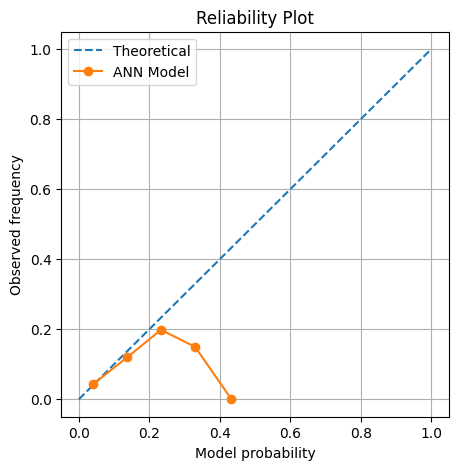

In [20]:
import matplotlib.pyplot as plt

def reliability_plot(y_true, y_proba, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    bin_ids = np.digitize(y_proba, bins) - 1
    accs = []
    confs = []

    for i in range(n_bins):
        mask = bin_ids == i
        if mask.any():
            accs.append(y_true[mask].mean())
            confs.append(y_proba[mask].mean())

    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [0, 1], linestyle="--", label="Theoretical")
    plt.plot(confs, accs, marker="o", label="ANN Model")
    plt.xlabel("Model probability")
    plt.ylabel("Observed frequency")
    plt.title("Reliability Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

reliability_plot(y_val, y_val_proba)
